In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle
from sklearn.utils import resample
from skimage.io import imread

In [2]:
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features
from cars_detector.makebox import non_max_suppression
from cars_detector.window_sliding import first_window_sliding, window_sliding_advanced
from cars_detector.hard_negative_sampling import hard_negative_sampling
from cars_detector.encoding import bounding_boxes_to_mask, run_length_encoding
from cars_detector.tracking import tracking

In [5]:
df_ground_truth = pd.read_csv('train.csv')

## Sampling of positive and negative examples

In [6]:
if os.path.isfile("data/pos_neg_samples/positive_samples.pkl") and os.path.isfile("data/pos_neg_samples/negative_samples.pkl"):
    print('load data')
    total_positive_samples = pickle.load(open('data/pos_neg_samples/positive_samples.pkl', 'rb'))
    total_negative_samples = pickle.load(open('data/pos_neg_samples/negative_samples.pkl', 'rb'))

else:
    total_positive_samples, total_negative_samples = sampling(df_ground_truth)
    pickle.dump(total_negative_samples,open('data/pos_neg_samples/negative_samples.pkl', 'wb'))
    pickle.dump(total_positive_samples,open('data/pos_neg_samples/positive_samples.pkl', 'wb'))
    


load data


In [7]:
total_positive_samples = random.sample(total_positive_samples, 10000)
total_negative_samples = random.sample(total_negative_samples, 20000)

## Data Augmentation

In [8]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.2
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/33631/cars_detection/venv/lib/python3.7/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 10000/10000 [00:00<00:00, 15473.04it/s]


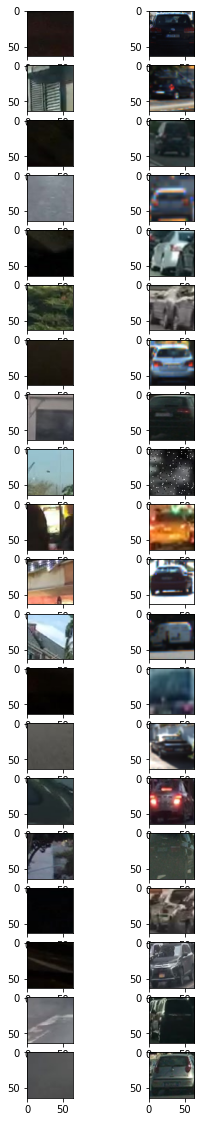

In [9]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)

fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]

        ax[i][j].imshow(img)

In [8]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 11950
number of negative samples: 20000


## Features computation

In [9]:
if os.path.isfile("data/features/positive_features.pkl") and os.path.isfile("data/features/negative_features.pkl"):
    print('load data')
    positive_features = pickle.load(open("data/features/positive_features.pkl", 'rb'))
    negative_features = pickle.load(open("data/features/negative_features.pkl", 'rb'))
else:
    print('compute features')
    positive_features = []
    for img in tqdm(total_positive_samples, position = 0):
        feat = compute_features(img)
        positive_features.append(feat)
    pickle.dump(positive_features,open("data/features/positive_features.pkl", 'wb'))

    negative_features = []
    for img in tqdm(total_negative_samples, position = 0):
        feat = compute_features(img)
        negative_features.append(feat)
    pickle.dump(positive_features,open("data/features/negative_features.pkl", 'wb'))

compute features


100%|██████████| 20000/20000 [00:55<00:00, 357.38it/s]


In [12]:
from sklearn.model_selection import train_test_split
import gc

if os.path.isfile("data/sets/X_train.pkl"):
    print('load data')
    X_train = pickle.load(open("data/sets/X_train.pkl", 'rb'))
    X_test = pickle.load(open("data/sets/X_test.pkl", 'rb'))
    y_train = pickle.load(open("data/sets/y_train.pkl", 'rb'))
    y_test = pickle.load(open("data/sets/y_test.pkl", 'rb'))

else:
    print("compute sets")
    X = np.concatenate((positive_features,negative_features), axis = 0)
    y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)
    pickle.dump(X_train,open("data/sets/X_train.pkl", 'wb'))
    pickle.dump(X_test,open("data/sets/X_test.pkl", 'wb'))
    pickle.dump(y_train,open("data/sets/y_train.pkl", 'wb'))
    pickle.dump(y_test,open("data/sets/y_test.pkl", 'wb'))
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.float32(X_train))
X_test_scaled = scaler.transform(np.float32(X_test))

load data


## Model Training

In [13]:
eval_set = [(X_test, y_test)]
if os.path.isfile('data/models/XGB.json'):
    print('load model')
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB.json")
    scaler = pickle.load(open("data/models/scaler.pkl",'rb'))
else:
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.fit(X_train_scaled, y_train)
    clf.save_model("data/models/XGB.json")
    pickle.dump(scaler,open("data/models/scaler.pkl",'wb'))

y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

load model
accuracy: 0.95320813771518


## False postive rate reduction through hard negative sampling

In [14]:
eval_set = [(X_test, y_test)]
if os.path.isfile('data/models/XGB_with_neg_sampling.json'):
    print('load model')
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB_with_neg_sampling.json")
    scaler = pickle.load(open("data/models/scaler.pkl",'rb'))
elif os.path.isfile('data/models/XGB.json'):
    print("hard negative sampling !")
    # load previous model
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB.json")
    scaler = pickle.load(open("data/models/scaler.pkl",'rb'))
    # compute negative samples
    hard_neg_samples = hard_negative_sampling(df_ground_truth, clf, scaler)
    pickle.dump(hard_neg_samples,open("data/pos_neg_samples/hard_neg_samples.pkl", 'wb'))
    # compute features
    hard_neg_samples_features = []
    for sample in hard_neg_samples:
        feat = compute_features(sample)
        hard_neg_samples_features.append(feat)
    # take a smaller sample of X_train and y_train
    X_train, y_train = resample(X_train, y_train, n_samples = np.int32(len(y_train)), random_state=0, stratify = y_train, replace = False)
    # create the new data set
    X_train = np.concatenate((X_train,hard_neg_samples_features), axis = 0)
    y_train = np.concatenate((y_train,[0 for i in range(len(hard_neg_samples_features))]), axis = 0)
    # scale data
    X_train_scaled = scaler.transform(np.float32(X_train))
    X_test_scaled = scaler.transform(np.float32(X_test))
    # train model
    clf.fit(X_train_scaled, y_train)
    # save model
    clf.save_model("data/models/XGB_with_neg_sampling.json")
else:
    print("train a regular classifier at first !")
    
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

load model
accuracy: 0.9320813771517997


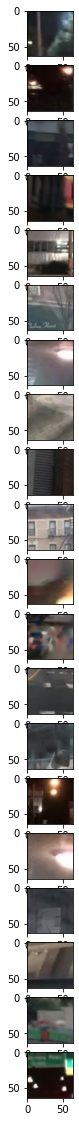

In [13]:
# hard negative samples visualisation
number_of_hard_neg_samples = len(hard_neg_samples)

fig, ax = plt.subplots(20,1,figsize=(2, 20))
for i in range(20):

    img = hard_neg_samples[np.random.randint(number_of_hard_neg_samples)]
    ax[i].imshow(img)

## Cascade Window Sliding

In [6]:
i = 140
img = imread('./test/'+str(i).zfill(3)+'.jpg')
boxes_list, pred_array = first_window_sliding(img, clf, scaler)

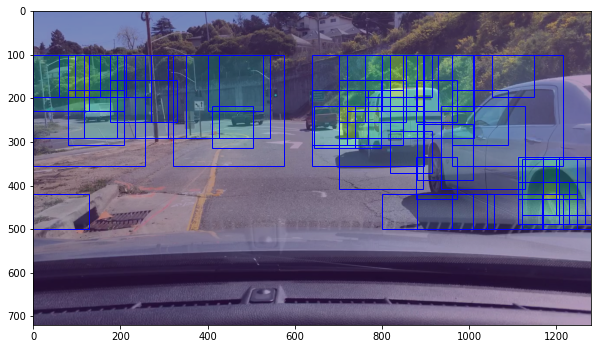

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in boxes_list:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)
ax.imshow(pred_array, alpha = 0.4)


In [9]:
boxes_list = non_max_suppression(np.array(boxes_list), overlapThresh=0.1)
boxes_list2, pred_array2 = window_sliding_advanced(img,boxes_list, clf, scaler)

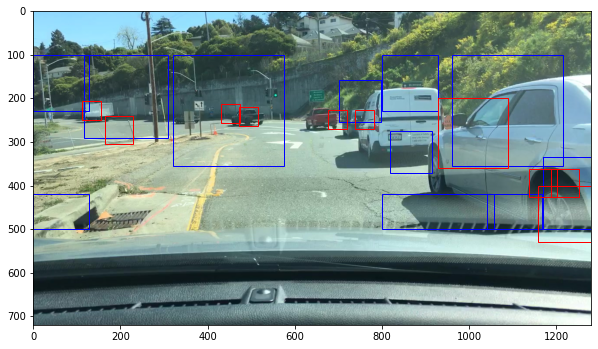

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in test:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
boxes_list2 = non_max_suppression(np.array(boxes_list2), overlapThresh=0.4)
for x, y, dx, dy in boxes_list2:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)


In [12]:
for i in tqdm(range(1,203), position = 0):
    if os.path.isfile("boxes_and_array.pkl"):
        boxes_and_array = pd.read_pickle("boxes_and_array.pkl")
    else:
        boxes_and_array = pd.DataFrame(columns = ['image','boxes', 'pred_array'])

    already_computed_images = list(boxes_and_array.image)
    if i in already_computed_images:
        continue
    else:
        # compute boxes
        img = imread('./test/'+str(i).zfill(3)+'.jpg')
        boxes_list, pred_array = first_window_sliding(img, clf, scaler)
        boxes_list = non_max_suppression(np.array(boxes_list), overlapThresh=0.1)
        boxes_list2, pred_array2 = window_sliding_advanced(img, boxes_list, clf, scaler)

        # append to dataframe
        line_to_add = pd.DataFrame([[i, boxes_list2, pred_array2]], columns = ['image','boxes', 'pred_array'])
        boxes_and_array  = pd.concat([boxes_and_array, line_to_add], axis = 0)


        # save to csv
        boxes_and_array.to_pickle("boxes_and_array.pkl")

100%|██████████| 202/202 [02:43<00:00,  1.23it/s]


## Add tracking

In [3]:
boxes_array = pd.read_pickle('boxes_and_array.pkl')

In [4]:
def compute_mask_dict():
    mask_dict = {}
    for h in range(1,203):
        img = imread('./test/'+str(h).zfill(3)+'.jpg')
        boxes = boxes_array.query('image==@h').boxes.values[0]
        mask_img = np.zeros((img.shape[0],img.shape[1]))
        for box in boxes:
            mask_img[box[1]:box[1]+box[3],box[0]:box[0]+box[2]] = 1
        mask_dict[h] = mask_img
    return(mask_dict)

In [5]:
mask_dict = compute_mask_dict()

To keep a box, check if it still exist in the next 5 frames (around the curent location)

In [28]:
def compute_tracked_boxes(mask_dict):
    df_for_colnames = pd.read_csv('sample_submission.csv').drop(index = [0])
    submission_df = pd.DataFrame(columns = df_for_colnames.columns)
    for i in range(1,203):
        boxes_to_keep = tracking(i,mask_dict,boxes_array,
                        search_radius = 1,
                        number_of_frames_to_look = 20,
                        freq_of_presence = 0.7)

        mask = bounding_boxes_to_mask(boxes_to_keep, 720, 1280)

        try:
            final_pred = run_length_encoding(mask)
            last_working_pred = final_pred
        except:
            # if no boxes are found we take the previous ones as predictions
            final_pred = last_working_pred

        line_to_add = pd.DataFrame([['test/'+str(i).zfill(3)+'.jpg', final_pred]], columns = submission_df.columns)
        submission_df  = pd.concat([submission_df, line_to_add], axis = 0)        
    return (submission_df)
 

In [29]:
submission_df = compute_tracked_boxes(mask_dict)
submission_df.to_csv('final_predictions.csv', index=False)